# Director Gender Bias in Movie Ratings

### Import Statements

In [1]:
!pip install scikit-surprise

In [2]:
import random
from sklearn import linear_model
from matplotlib import pyplot as plt
from collections import defaultdict
import gzip
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import json
import numpy
import dateutil.parser
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.optimize
from sklearn import svm
import string
import random

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
# from implicit.als import AlternatingLeastSquares
import numpy as np
import os
import tarfile
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score

In [3]:
#Install AIF360
!pip install 'aif360'

ERROR: Invalid requirement: "'aif360'"


In [4]:
# Install TensorFlow
!pip install 'tensorflow==2.6.0'

ERROR: Invalid requirement: "'tensorflow==2.6.0'"


In [5]:
pip install 'aif360[LawSchoolGPA]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[LawSchoolGPA]'"


In [6]:
pip install --upgrade tensorflow aif360

  Using cached protobuf-4.25.2-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl.metadata (540 bytes)
Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl (422 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.0
    Uninstalling protobuf-3.19.0:
      Successfully uninstalled protobuf-3.19.0
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install protobuf==3.19.0

  Using cached protobuf-3.19.0-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 3.19.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.0 which is incompatible.


In [8]:
pip install 'aif360[AdversarialDebiasing]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[AdversarialDebiasing]'"


In [9]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


### Reading File Path (Ratings, Users, Movies, Directors, Titles)

In [45]:
# Update the file paths based on your extraction path
extract_path = ""

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Users File
users_file = os.path.join(extract_path, "users.dat")
users_columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users_df = pd.read_csv(users_file, sep="::", engine="python", header=None, names=users_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

In [11]:
# Directors File
directors_file = os.path.join(extract_path, "directors.json")
directors_df = pd.read_json(directors_file)

In [12]:
# Titles File
titles_file = os.path.join(extract_path, "title.basics.tsv.gz")
titles_df = pd.read_csv(titles_file, compression='gzip', sep='\t', encoding='utf-8')

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


### Separting Title of Movie from the Year in Movies Dataframe

In [13]:
import re

# Separate title of movie from the year
movies_df['Year'] = movies_df['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)
movies_df['Title'] = movies_df['Title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())
movies_df

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000
3879,3949,Requiem for a Dream,Drama,2000
3880,3950,Tigerland,Drama,2000
3881,3951,Two Family House,Drama,2000


### For Titles Dataframe, We Want the Title Type to Only Be Movies

In [14]:
# Filter to get titles that are only associated with movies
titles_df = titles_df[titles_df['titleType'] == 'movie']
titles_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
10491987,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
10492014,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
10492026,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
10492036,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


### Merge the Movies Dataframe and Titled Dataframe Together Given Movie Title and Year

In [15]:
# Merge datasets using Title of movie and year

movie_ids = pd.merge(movies_df, titles_df, left_on=['Title', 'Year'], right_on=['primaryTitle', 'startYear'], how='left')
movie_ids

,MovieID,Title,Genres,Year,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy"
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family"
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance"
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance"
4,5,Father of the Bride Part II,Comedy,1995,tt0113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3948,Meet the Parents,Comedy,2000,tt0212338,movie,Meet the Parents,Meet the Parents,0,2000,\N,108,"Comedy,Romance"
3896,3949,Requiem for a Dream,Drama,2000,tt0180093,movie,Requiem for a Dream,Requiem for a Dream,0,2000,\N,102,Drama
3897,3950,Tigerland,Drama,2000,tt0170691,movie,Tigerland,Tigerland,0,2000,\N,101,"Drama,War"
3898,3951,Two Family House,Drama,2000,tt0202641,movie,Two Family House,Two Family House,0,2000,\N,108,"Comedy,Drama,Romance"


### Get Director Gender Given Movie Using Directors Dataframe

In [16]:
# Find gender of each movie identifier associated with the director

genders = directors_df.explode('movies_list')
genders = pd.concat([genders.drop(['movies_list'], axis=1),
                         genders['movies_list'].apply(pd.Series)], axis=1)

### Merging Datasets from Movie and Gender (Director) Datafrane Given Movie ID

In [17]:
# Combine datasets based on movie identifier 

merged_df = pd.merge(movie_ids, genders, left_on='tconst', right_on='movie_id', how='left')
merged_df = merged_df.loc[:, ['MovieID', 'Title', 'Genres', 'Year', 'male_count', 'gender', 'name', 'female_count']]
merged_df

,MovieID,Title,Genres,Year,male_count,gender,name,female_count
0,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,11.0,male,Joe Johnston,0.0
2,3,Grumpier Old Men,Comedy|Romance,1995,3.0,male,Howard Deutch,0.0
3,4,Waiting to Exhale,Comedy|Drama,1995,116.0,male,Forest Whitaker,5.0
4,5,Father of the Bride Part II,Comedy,1995,2.0,male,Charles Shyer,0.0
...,...,...,...,...,...,...,...,...
4075,3948,Meet the Parents,Comedy,2000,8.0,male,Jay Roach,0.0
4076,3949,Requiem for a Dream,Drama,2000,33.0,male,Darren Aronofsky,3.0
4077,3950,Tigerland,Drama,2000,24.0,male,Joel Schumacher,3.0
4078,3951,Two Family House,Drama,2000,NaN,NaN,NaN,NaN


### Checking for Null Values for Each Dataframe

In [18]:
# Check for null values in merged movies dataset
merged_df.isnull().sum()

MovieID            0
Title              0
Genres             0
Year               0
male_count      2298
gender          2298
name            2298
female_count    2298
dtype: int64

In [19]:
# Check for null values in Ratings file
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [20]:
# Check for null values in Users file
users_df.isnull().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [21]:
# Check for null values in Movies file

movies_df.isnull().sum()

MovieID    0
Title      0
Genres     0
Year       0
dtype: int64

## Data Cleaning EDA

### Movies Dataframe - Number of Movies by Year

In [22]:
%matplotlib inline

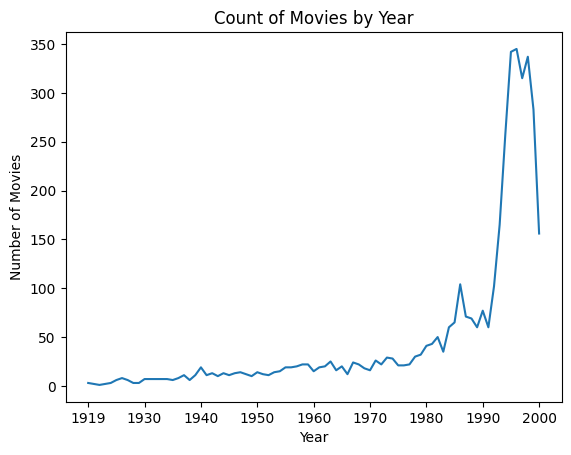

In [23]:
# Number of Movies in dataset by Year

movies_df['Year'].value_counts().sort_index().plot()
plt.ylabel('Number of Movies')
plt.xlabel('Year')
plt.title('Count of Movies by Year')
plt.show()

### Ratings Dataframe - Looking at Distribution of Rating Scores, Years, Months, and Hours

Text(0, 0.5, 'Count')

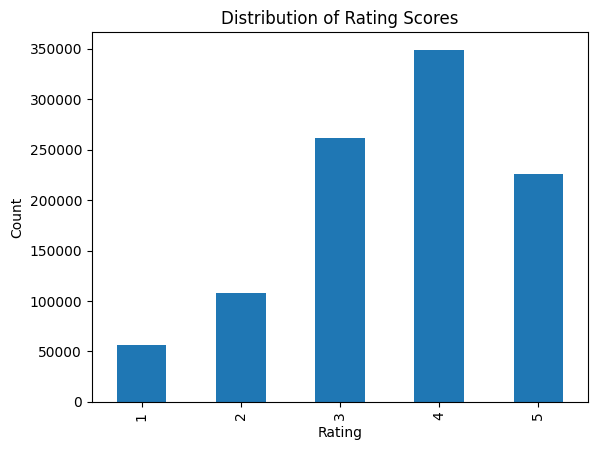

In [24]:
# Plot distribution of rating scores
ratings_df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating Scores')
plt.ylabel('Count')

# There do not appear to be any placeholders for missing vals
# Most ratings are 4 stars, the least amount of ratings are 1 star

Text(0, 0.5, 'Count')

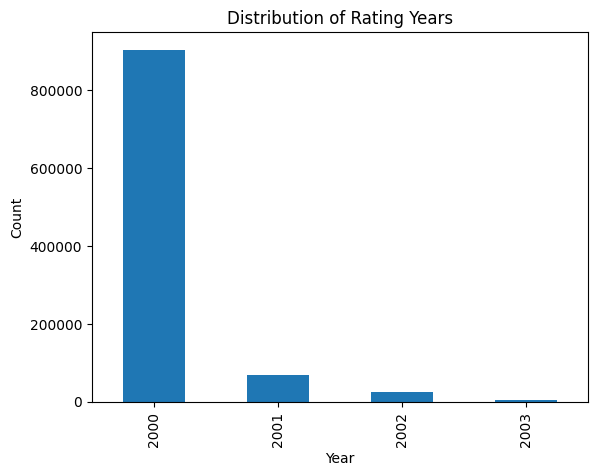

In [25]:
# Convert Timestamp col to datetime objects for visualizations
datetime = pd.to_datetime(ratings_df['Timestamp'], unit='s')

# Plot year of rating
datetime.dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating Years')
plt.xlabel('Year')
plt.ylabel('Count')

# Almost all ratings are from 2000

Text(0, 0.5, 'Count')

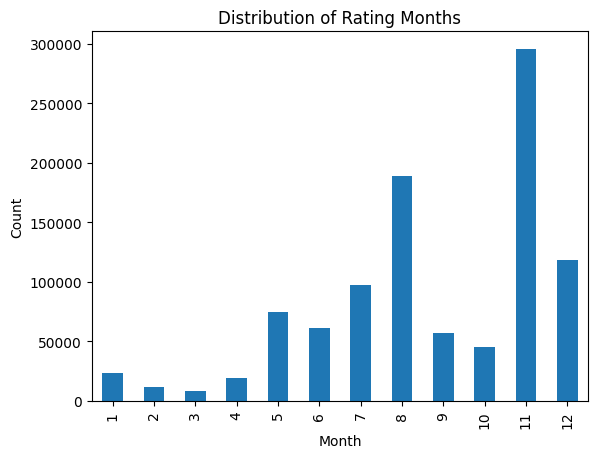

In [26]:
# Plot months of rating
datetime.dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating Months')
plt.xlabel('Month')
plt.ylabel('Count')

# Most ratings are from November

Text(0, 0.5, 'Count')

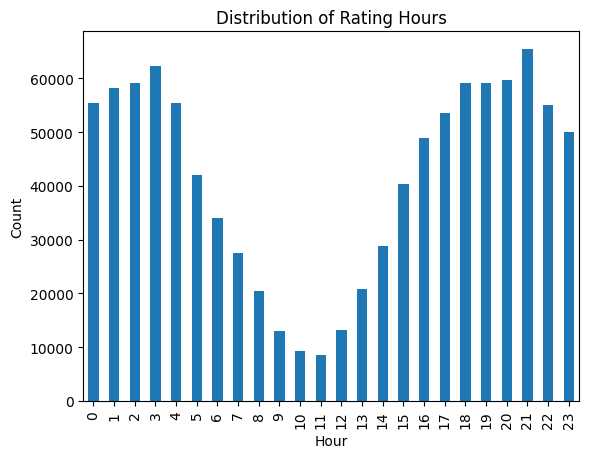

In [27]:
# Plot hour of rating
datetime.dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating Hours')
plt.xlabel('Hour')
plt.ylabel('Count')

# Most ratings happen at the beginning of the day or the end, as that's where peaks happen.

In [28]:
# There do not appear to be any placeholders for null values
ratings_df['UserID'].min(), ratings_df['UserID'].max()

(1, 6040)

In [29]:
# Top 5 user IDs who left the most ratings
ratings_df['UserID'].value_counts()[:5]

UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: count, dtype: int64

In [30]:
# There do not appear to be any placeholders for null values
ratings_df['MovieID'].min(), ratings_df['MovieID'].max()

(1, 3952)

### Users Dataframe - Checking for Distribution of Gender and Age in Users

Text(0, 0.5, 'Count')

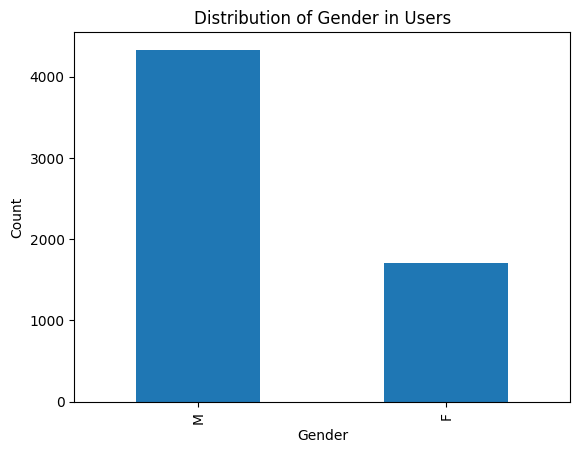

In [31]:
# Distribution of Gender in Users
users_df['Gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender in Users')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

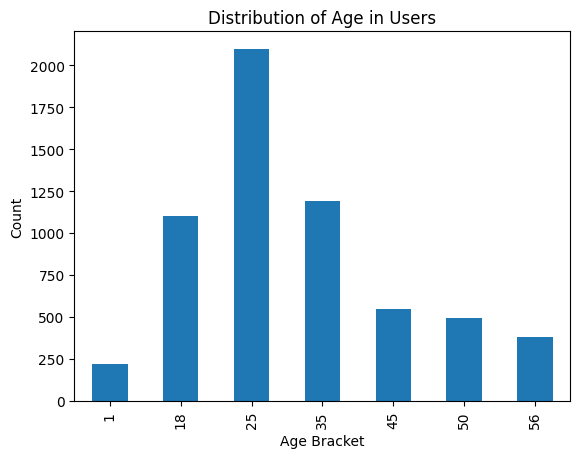

In [32]:
# Distribution of Age in Users
users_df['Age'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Age in Users')
plt.xlabel('Age Bracket')
plt.ylabel('Count')

### Merging Movies Dataframe with Ratings Dataframe on MovieID to Include Rating and UserID Columns

In [33]:
# Merge Movies with Ratings on MovieID

Ratings_and_Movies = pd.merge(merged_df, ratings_df[['MovieID', 'Rating', 'UserID']], on='MovieID')
Ratings_and_Movies

,MovieID,Title,Genres,Year,male_count,gender,name,female_count,Rating,UserID
0,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,1
1,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,4,6
2,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,4,8
3,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,9
4,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,10
...,...,...,...,...,...,...,...,...,...,...
1086284,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,4,5812
1086285,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,3,5831
1086286,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,4,5837
1086287,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,1,5927


### Renaming Columns in New Ratings_and_Movies Dataframe for Clarity, Merging User Demographic Information into This Dataframe, and Removing Null Values

In [34]:
users_df.rename(columns={'Rating': 'User_Rating','Gender': 'User_Gender', 'Age': 'User_Age', 'Occupation': 'User_Occupation', 'Zip-code': 'User_Zip-code'}, inplace=True)

# Merge user demographic info with ratings
Ratings_and_Movies = pd.merge(Ratings_and_Movies, users_df[['UserID', 'User_Gender', 'User_Age', 'User_Occupation', 'User_Zip-code']], on='UserID')

Ratings_and_Movies.rename(columns={'Rating': 'User_Rating'}, inplace=True)

# Remove null values
Ratings_and_Movies = Ratings_and_Movies.dropna(subset=['male_count', 'gender', 'female_count'])

### Enuring That We Are Only Keeping Revelant Columns in Dataframe

In [35]:
# Select relevant columns
Ratings_and_Movies = Ratings_and_Movies[['Title', 'MovieID', 'Genres', 'Year', 'male_count', 'gender', 'female_count', 'User_Rating', 'UserID', 'User_Gender', 'User_Age', 'User_Occupation']]

### Creating Binary Values for Director Gender and User Gender Columns

In [36]:
# Replace 'male' and 'female' with numerical binary values

Ratings_and_Movies['gender'] = Ratings_and_Movies['gender'].replace({'female': 0, 'male': 1})
Ratings_and_Movies['User_Gender'] = Ratings_and_Movies['User_Gender'].replace({'F': 0, 'M': 1})
Ratings_and_Movies

,Title,MovieID,Genres,Year,male_count,gender,female_count,User_Rating,UserID,User_Gender,User_Age,User_Occupation
0,Toy Story,1,Animation|Children's|Comedy,1995,37.0,1,4.0,5,1,0,1,10
1,Pocahontas,48,Animation|Children's|Musical|Romance,1995,3.0,1,0.0,5,1,0,1,10
2,Pocahontas,48,Animation|Children's|Musical|Romance,1995,10.0,1,0.0,5,1,0,1,10
4,Apollo 13,150,Drama,1995,58.0,1,13.0,5,1,0,1,10
6,Star Wars: Episode IV - A New Hope,260,Action|Adventure|Fantasy|Sci-Fi,1977,154.0,1,0.0,4,1,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...,...
1086284,Rules of Engagement,3513,Drama|Thriller,2000,61.0,1,0.0,4,5727,1,25,4
1086285,American Psycho,3535,Comedy|Horror|Thriller,2000,1.0,0,7.0,2,5727,1,25,4
1086286,Keeping the Faith,3536,Comedy|Romance,2000,112.0,1,3.0,5,5727,1,25,4
1086287,U-571,3555,Action|Thriller,2000,7.0,1,7.0,3,5727,1,25,4


In [37]:
# Check for null values
Ratings_and_Movies.isnull().sum()

Title              0
MovieID            0
Genres             0
Year               0
male_count         0
gender             0
female_count       0
User_Rating        0
UserID             0
User_Gender        0
User_Age           0
User_Occupation    0
dtype: int64

### Creating New Genre Column and Creating Binary Columns for Each Genre for Clarity. Previously All Genres Were Strings like “Action|Comedy”

In [38]:
# Split the genres column into a list of genres
Ratings_and_Movies['Genres'] = Ratings_and_Movies['Genres'].str.split('|')

# Create a list of unique genres
unique_genres = set(genre for genres_list in Ratings_and_Movies['Genres'] for genre in genres_list)

# Create binary columns for each genre and initialize them with zeros
for genre in unique_genres:
     Ratings_and_Movies[genre] = 0

# Update the binary columns with 1 if the genre is present in the list
for index, row in Ratings_and_Movies.iterrows():
     for genre in row['Genres']:
         Ratings_and_Movies.at[index, genre] = 1

# Drop the original genres column
df = Ratings_and_Movies.drop('Genres', axis=1)

### Creating New Feature - Male & Female Director Proportions

In [39]:
# Find proportion of male directors for each movie
male_prop_dict = dict(df.groupby('MovieID')['gender'].sum() / df.groupby('MovieID')['gender'].count())

### Keep 1 row per Movie per User (multiple rows before due to multiple directors)

In [40]:
# Add column with proportion of male directors & proportion of female directors for each row
df['male_director_proportion'] = df['MovieID'].map(male_prop_dict)
df['female_director_proportion'] =  1 - df['male_director_proportion']

df = df.drop_duplicates( 
  subset = ['MovieID', 'UserID'], 
  keep = 'last').reset_index(drop = True) 

df

,Title,MovieID,Year,male_count,gender,female_count,User_Rating,UserID,User_Gender,User_Age,...,Film-Noir,Mystery,Thriller,Musical,Crime,Drama,Western,Comedy,male_director_proportion,female_director_proportion
0,Toy Story,1,1995,37.0,1,4.0,5,1,0,1,...,0,0,0,0,0,0,0,1,1.0,0.0
1,Pocahontas,48,1995,10.0,1,0.0,5,1,0,1,...,0,0,0,1,0,0,0,0,1.0,0.0
2,Apollo 13,150,1995,58.0,1,13.0,5,1,0,1,...,0,0,0,0,0,1,0,0,1.0,0.0
3,Star Wars: Episode IV - A New Hope,260,1977,154.0,1,0.0,4,1,0,1,...,0,0,0,0,0,0,0,0,1.0,0.0
4,Schindler's List,527,1993,320.0,1,25.0,5,1,0,1,...,0,0,0,0,0,1,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597784,Rules of Engagement,3513,2000,61.0,1,0.0,4,5727,1,25,...,0,0,1,0,0,1,0,0,1.0,0.0
597785,American Psycho,3535,2000,1.0,0,7.0,2,5727,1,25,...,0,0,1,0,0,0,0,1,0.0,1.0
597786,Keeping the Faith,3536,2000,112.0,1,3.0,5,5727,1,25,...,0,0,0,0,0,0,0,1,1.0,0.0
597787,U-571,3555,2000,7.0,1,7.0,3,5727,1,25,...,0,0,1,0,0,0,0,0,1.0,0.0


### Renaming Columns in Finalized Dataframe for Clarity

In [41]:
# Assuming df is your DataFrame
df.columns = df.columns.str.lower()

# If you want to rename specific columns
column_mapping = {
    'Title': 'title',
    'MovieID': 'movie_id',
    'Year': 'year',
    'male_count': 'male_count',
    'gender': 'director_gender',
    'female_count': 'female_count',
    'User_Rating': 'user_rating',
    'UserID': 'user_id',
    'User_Gender': 'user_gender',
    'User_Age': 'user_age',
    'User_Occupation': 'user_occupation',
    'Drama': 'drama',
    'Romance': 'romance',
    'Thriller': 'thriller',
    'Action': 'action',
    'Sci-Fi': 'sci_fi',
    'Adventure': 'adventure',
    'Mystery': 'mystery',
    'Comedy': 'comedy',
    "Children's": 'childrens',
    'Animation': 'animation',
    'War': 'war',
    'Western': 'western',
    'Documentary': 'documentary',
    'Film-Noir': 'film_noir',
    'Horror': 'horror',
    'Fantasy': 'fantasy',
    'Crime': 'crime',
    'Musical': 'musical',
    'male_director_proportion': 'male_director_proportion',
    'female_director_proportion': 'female_director_proportion'
}

df.rename(columns=column_mapping, inplace=True)
df.drop(['male_count', 'female_count'], axis=1, inplace=True)


df

,title,movieid,year,director_gender,user_rating,userid,user_gender,user_age,user_occupation,children's,...,film-noir,mystery,thriller,musical,crime,drama,western,comedy,male_director_proportion,female_director_proportion
0,Toy Story,1,1995,1,5,1,0,1,10,1,...,0,0,0,0,0,0,0,1,1.0,0.0
1,Pocahontas,48,1995,1,5,1,0,1,10,1,...,0,0,0,1,0,0,0,0,1.0,0.0
2,Apollo 13,150,1995,1,5,1,0,1,10,0,...,0,0,0,0,0,1,0,0,1.0,0.0
3,Star Wars: Episode IV - A New Hope,260,1977,1,4,1,0,1,10,0,...,0,0,0,0,0,0,0,0,1.0,0.0
4,Schindler's List,527,1993,1,5,1,0,1,10,0,...,0,0,0,0,0,1,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597784,Rules of Engagement,3513,2000,1,4,5727,1,25,4,0,...,0,0,1,0,0,1,0,0,1.0,0.0
597785,American Psycho,3535,2000,0,2,5727,1,25,4,0,...,0,0,1,0,0,0,0,1,0.0,1.0
597786,Keeping the Faith,3536,2000,1,5,5727,1,25,4,0,...,0,0,0,0,0,0,0,1,1.0,0.0
597787,U-571,3555,2000,1,3,5727,1,25,4,0,...,0,0,1,0,0,0,0,0,1.0,0.0


### Director Gender EDA

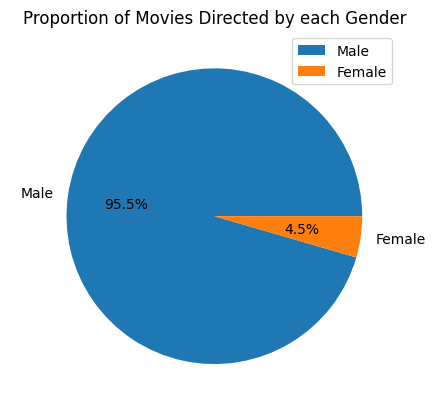

In [42]:
# Proportion of movies in dataset directed by each gender

gender_labels = df['director_gender'].map({1: 'Male', 0: 'Female'})
props = gender_labels.value_counts() / gender_labels.value_counts().sum()
plot = props.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel(' ')
plt.title('Proportion of Movies Directed by each Gender')
plt.legend(labels=props.index, loc="best")
    
plt.show()

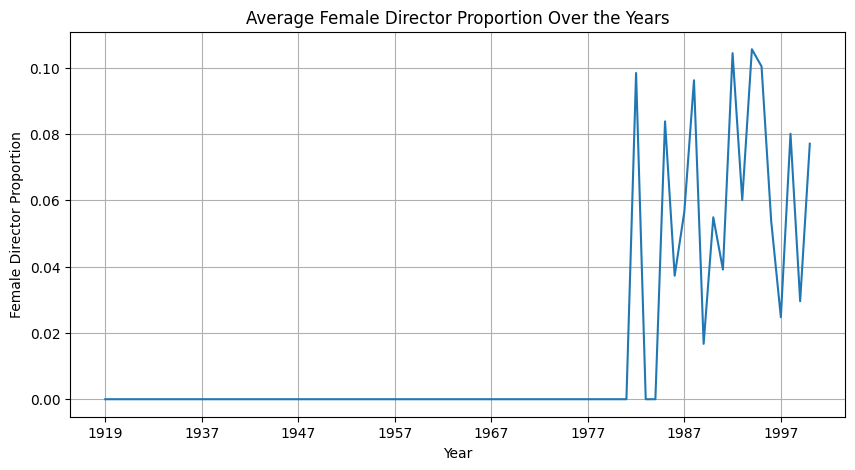

In [43]:
# Average female_director_proportion by year

plt.figure(figsize=(10, 5))
df.groupby('year')['female_director_proportion'].mean().plot()
plt.title('Average Female Director Proportion Over the Years')
plt.xlabel('Year')
plt.ylabel('Female Director Proportion')
plt.grid(True)
plt.show()

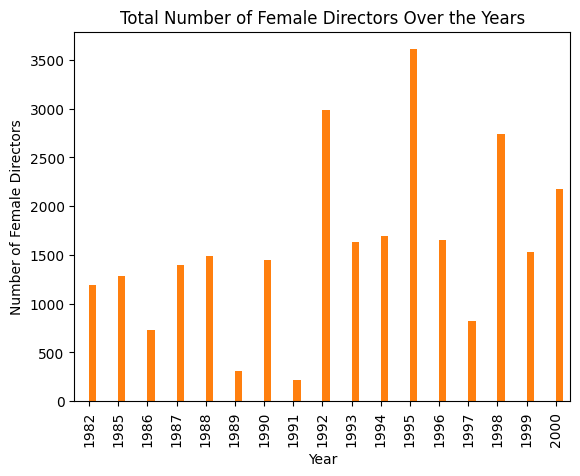

In [44]:
import matplotlib.pyplot as plt

dir_gender_by_year = df.groupby('year')['director_gender'].value_counts().sort_index().reset_index()

female_directors_by_year = dir_gender_by_year[dir_gender_by_year['director_gender'] == 0]

# Setting the year as index
female_directors_by_year.set_index('year', inplace=True)

# Plotting
female_directors_by_year.plot(kind='bar', legend=None)
plt.title('Total Number of Female Directors Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Female Directors')
plt.show()

In [46]:
df.columns

Index(['movieid', 'year', 'director_gender', 'user_rating', 'userid',
       'user_gender', 'user_age', 'user_occupation', 'fantasy', 'western',
       'comedy', 'crime', 'thriller', 'mystery', 'documentary', 'drama',
       'adventure', 'action', 'war', 'film-noir', 'animation', 'romance',
       'children's', 'musical', 'horror', 'sci-fi', 'male_director_proportion',
       'female_director_proportion'],
      dtype='object')

In [ ]:
# Grouping data by gender and genre, and calculating counts
genre_counts_by_gender = df.groupby('director_gender').sum()[['action', "children's", 'comedy', 'adventure', 'fantasy', 'romance', 'drama', 'thriller', 'horror', 'sci-fi', 'crime', 'animation', 'mystery', 'war', 'musical', 'documentary', 'western', 'film-noir']]

# Calculate total movies by gender
total_movies_by_gender = df['director_gender'].value_counts()

# Calculate percentages
genre_percentage_by_gender = genre_counts_by_gender.div(total_movies_by_gender, axis=0) * 100

In [ ]:
# Plotting
ax = genre_percentage_by_gender.transpose().plot(kind='bar', stacked=True)

# Set custom x-axis labels
ax.set_xticks(range(len(genre_percentage_by_gender.columns)))
ax.set_xticklabels(genre_percentage_by_gender.columns, rotation=45, ha='right')

# Set custom legend
plt.legend(title='Director Gender', labels=['Female', 'Male'])

plt.title('Percentage of Each Genre Among Movies Directed by Male and Female Directors')
plt.xlabel('Genre')
plt.ylabel('Percentage')

plt.show()

### Director Bias EDA

In [52]:
merged_users = ratings_df.merge(users_df[['UserID', 'Age', 'Gender', 'Occupation']], on='UserID')
merged_users['User_Gender'] = merged_users['Gender'].replace({'F': 0, 'M': 1})

Proportion of Star Ratings per Gender:
user_rating             1         2         3         4         5
director_gender                                                  
0                0.066238  0.128610  0.302345  0.348140  0.154667
1                0.056898  0.110092  0.264464  0.346982  0.221564


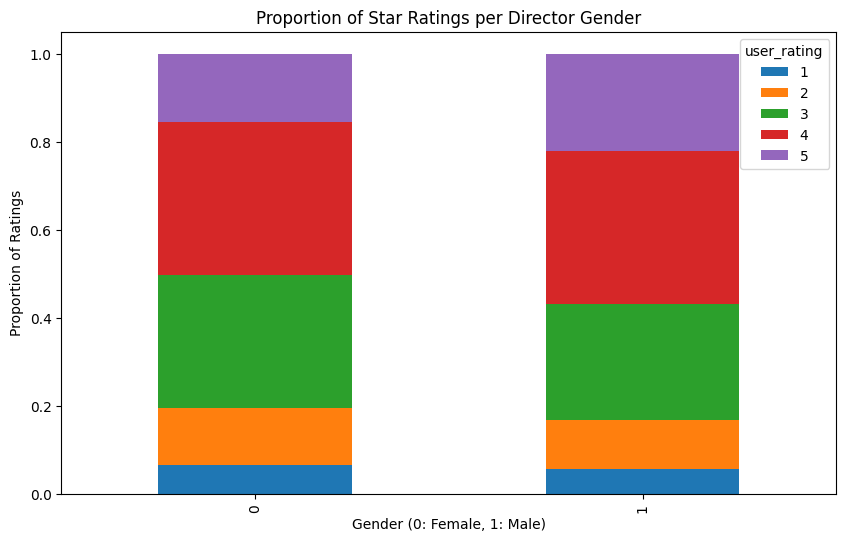

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Director Gender and Rating received, then calculate the count
grouped_data_gender = df.groupby(['director_gender', 'user_rating']).size().unstack().fillna(0)

# Calculate the total count of ratings received for each director gender
total_ratings_by_gender = df['director_gender'].value_counts()

# Calculate proportions by dividing each count by the total count of ratings received for each director gender
proportion_data_gender = grouped_data_gender.div(total_ratings_by_gender, axis=0)

# Print the specific values
print("Proportion of Star Ratings per Gender:")
print(proportion_data_gender)

# Plot the bar plot
proportion_data_gender.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Proportion of Ratings')
plt.title('Proportion of Star Ratings per Director Gender')

# Show the plot
plt.show()

### Checking for Bias with AIF360

#### Remove non-numerical column (title) to make dataset compatible with AIF360

In [62]:
movie_titles = df['title']
df = df.drop('title', axis=1)
df

,movieid,year,director_gender,user_rating,userid,user_gender,user_age,user_occupation,children's,documentary,...,film-noir,mystery,thriller,musical,crime,drama,western,comedy,male_director_proportion,female_director_proportion
0,1,1995,1,5,1,0,1,10,1,0,...,0,0,0,0,0,0,0,1,1.0,0.0
1,48,1995,1,5,1,0,1,10,1,0,...,0,0,0,1,0,0,0,0,1.0,0.0
2,150,1995,1,5,1,0,1,10,0,0,...,0,0,0,0,0,1,0,0,1.0,0.0
3,260,1977,1,4,1,0,1,10,0,0,...,0,0,0,0,0,0,0,0,1.0,0.0
4,527,1993,1,5,1,0,1,10,0,0,...,0,0,0,0,0,1,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597784,3513,2000,1,4,5727,1,25,4,0,0,...,0,0,1,0,0,1,0,0,1.0,0.0
597785,3535,2000,0,2,5727,1,25,4,0,0,...,0,0,1,0,0,0,0,1,0.0,1.0
597786,3536,2000,1,5,5727,1,25,4,0,0,...,0,0,0,0,0,0,0,1,1.0,0.0
597787,3555,2000,1,3,5727,1,25,4,0,0,...,0,0,1,0,0,0,0,0,1.0,0.0


In [63]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Define the protected attributes
protected_attributes = ['male_director_proportion']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(df, label_name='user_rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[[1]])  # Only one class for User_Gender (e.g., male is privileged)

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'male_director_proportion': 0}],
                                         privileged_groups=[{'male_director_proportion': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)
print("Statistical Parity Difference Before Mitigation:", metric_before.statistical_parity_difference())

# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'male_director_proportion': 0}], privileged_groups=[{'male_director_proportion': 1}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'male_director_proportion': 0}],
                                        privileged_groups=[{'male_director_proportion': 1}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)
print("Statistical Parity Difference After Mitigation:", metric_after.statistical_parity_difference())

Disparate Impact Before Mitigation: 0.6973606043589647
Statistical Parity Difference Before Mitigation: -0.06730709172968116
Disparate Impact After Mitigation: 1.0000000000000004
Statistical Parity Difference After Mitigation: 1.1102230246251565e-16


### Analysis from Disparate Impact Score:
- The output 'Disparate Impact Before Mitigation: 0.6633064310198241' indicates a disparate impact of 0.66, suggesting bias in ratings based on the director's gender. Since 66% falls under the 3/4ths rule, it signifies a substantial bias. In the context of disparate impact, this value reflects an imbalance, indicating that certain groups, possibly based on gender, may be disproportionately affected by the ratings.

### Linear Regression Model to Predict User Rating Based on Selected Features

In [64]:
# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

In [65]:
# Predict Rating Model

# Select features and target variable

features = ['user_age', 'user_occupation', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
            'children\'s', 'film-noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 'action', 'mystery', 'war', 'musical', 'animation', 'sci-fi', 'male_director_proportion']

target = 'user_rating'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# With director gender proportions: MSE = 1.1814336725581673
# With director_gender column: MSE = 1.1817967538904501
# Without director gender proportions: MSE = 1.183496311127169

# Slightly more accurate when you INCLUDE director gender 
# Most accurate when you only include director gender proportion

Mean Squared Error: 1.188829521110468


### Same Linear Regression Model, but Filtering for Gender Director Proportion Separately to Observe Any Potential Bias in Ratings

In [66]:
#Predicting rating for men and women
# Select common features
common_features = ['user_age', 'user_occupation', 'documentary', 'romance', 'fantasy', 'western', 'thriller',
            'children\'s', 'film-noir', 'drama', 'comedy', 'adventure', 'horror', 'crime', 'action', 'mystery', 'war', 'musical', 'animation', 'sci-fi', 'male_director_proportion','male_director_proportion']

# Filter data for men and women separately
df_men = df[df['director_gender'] == 1]
df_women = df[df['director_gender'] == 0]

# Function to train and evaluate a model
def train_and_evaluate(data, gender):
    X = data[common_features]
    y = data['user_rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {gender}: {mse}')

# Train and evaluate models for men and women
train_and_evaluate(df_men, 'Men')
train_and_evaluate(df_women, 'Women')

# Analysis on output: Predicting Rating for women directed movies gave a lower MSE, so more accurate for predicting ratings for female directed movies?

Mean Squared Error for Men: 1.1945643753932582
Mean Squared Error for Women: 1.1541519341943054


### Built Recommender System for Recommending Top 5 Movies to Users Based on Jaccard Similarity

In [115]:
# Create a Movie-User matrix
movie_user_matrix = df.pivot_table(index='movieid', columns='userid', values='user_rating', fill_value=0)

# Function to calculate Jaccard similarity between two movies
def calculate_jaccard_similarity(movie1, movie2):
    intersection = sum((movie1 > 0) & (movie2 > 0))
    union = sum((movie1 > 0) | (movie2 > 0))
    
    if union == 0:
        return 0
    
    return intersection / union

# Function to generate movie recommendations based on Jaccard similarity
def generate_movie_recommendations(user_id, movie_user_matrix, df_movies, top_n=5):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['movieid'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_jaccard_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Jaccard similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Jaccard_Score'
    recommendations = recommendations.rename(columns={0: 'Jaccard_Similarity'})
    
    return recommendations

### Find top 5 movies for any given user ID

In [124]:
# Example: Recommend top 5 movies for User ID 1
user_id_to_recommend = 1
recommended_movies = generate_movie_recommendations(user_id_to_recommend, movie_user_matrix, df[['movieid']], top_n=5)

print(f"Top 5 Recommended Movies for User ID {user_id_to_recommend}:\n", recommended_movies)

Top 5 Recommended Movies for User ID 1:
   movieid  Jaccard_Similarity
0    1265            0.459450
1     356            0.403549
2    1580            0.394260
3    2396            0.382033
4    1196            0.379151


### Plotted director gender proportion of top 5 movies recommended to user

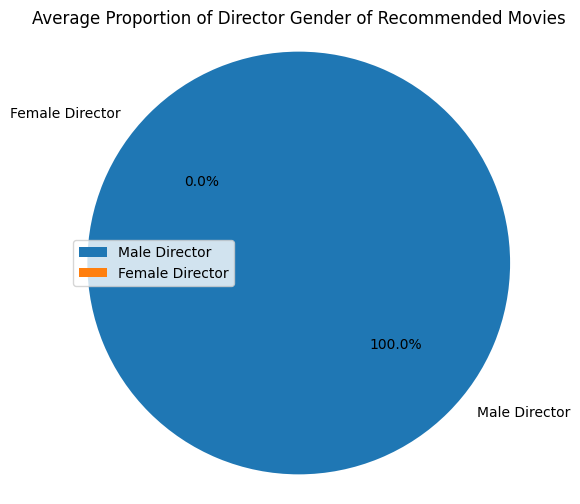

In [120]:
# Calculate mean male director proportion of recommended movies
mean_male_director_proportion = df[df['movieid'].isin(list(recommended_movies['movieid']))].drop_duplicates(subset='movieid')['male_director_proportion'].mean()

# Calculate female director proportion
mean_female_director_proportion = 1 - mean_male_director_proportion

# Data for the pie chart
labels = ['Male Director', 'Female Director']
sizes = [mean_male_director_proportion, mean_female_director_proportion]

# Plotting the pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Average Proportion of Director Gender of Recommended Movies')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding legend and labels
plt.legend()

# Show plot
plt.show()

### Plotted director gender proportion based on user's watch history

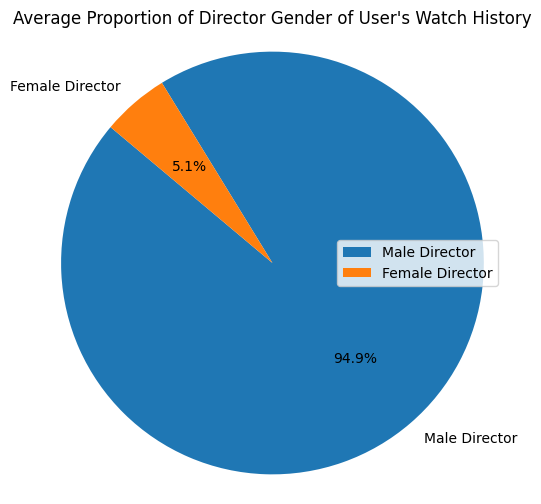

In [123]:
# Average male director proportion of movies watched by user
mean_male_director_proportion = df[df['userid'] == user_id_to_recommend]['male_director_proportion'].mean()

# Calculate female director proportion
mean_female_director_proportion = 1 - mean_male_director_proportion

# Data for the pie chart
labels = ['Male Director', 'Female Director']
sizes = [mean_male_director_proportion, mean_female_director_proportion]

# Plotting the pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Average Proportion of Director Gender of User's Watch History")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Adding legend and labels
plt.legend()

# Show plot
plt.show()